In [1]:
# Import Dependencies
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import pickle
import joblib
import csv

## Import and Check Chicago Crime Datasets

In [2]:
# Import 2016-2019 crime data
crime_2016 = os.path.join("..","Resources", "crime_clean_2016.csv") 
crime_2017 = os.path.join("..","Resources", "crime_clean_2017.csv")
crime_2018 = os.path.join("..","Resources", "crime_clean_2018.csv")
crime_2019 = os.path.join("..","Resources", "crime_clean_2019.csv")

crime_2016_df_final = pd.read_csv(crime_2016)
crime_2017_df_final = pd.read_csv(crime_2017)
crime_2018_df_final = pd.read_csv(crime_2018)

# 2019 is the test data
test_data = pd.read_csv(crime_2019)

# Join datasets for 2016, 2017, and 2018 for the training data
join1 = crime_2016_df_final.append(crime_2017_df_final)
training_data = join1.append(crime_2018_df_final)
X = training_data.append(test_data).copy()

In [3]:
#function to Convert data to numbers
from sklearn import preprocessing
def convert(data):
    number = preprocessing.LabelEncoder()
    data['date'] = number.fit_transform(data.date)
    data['time'] = number.fit_transform(data.time)
    data['block'] = number.fit_transform(data.block)
    data['description'] = number.fit_transform(data.description)
    data['location_description'] = number.fit_transform(data.location_description)
    data['iucr'] = number.fit_transform(data.iucr)
    data['fbi_code'] = number.fit_transform(data.fbi_code)
    data['primary_type'] = number.fit_transform(data.primary_type)
    data['domestic'] = number.fit_transform(data.domestic)
    data['latitude'] = number.fit_transform(data.latitude)
    data['longitude'] = number.fit_transform(data.longitude)
    data['arrest'] = number.fit_transform(data.arrest)
    return data

In [4]:
number = preprocessing.LabelEncoder()
c = X['location_description'].unique()
b = X['primary_type'].unique()
encoded_loc = number.fit_transform(c).astype('int')
encoded_type = number.fit_transform(b).astype('int')
loc_dict = dict(zip(c,encoded_loc))
type_dict = dict(zip(b,encoded_type))

file = os.path.join("..","Resources", "loc_dict.csv") 

w = csv.writer(open(file, "w"))
for key, val in loc_dict.items():
    w.writerow([key, val])

file = os.path.join("..","Resources", "loc_dict.csv") 

w = csv.writer(open(file, "w"))
for key, val in type_dict.items():
    w.writerow([key, val])    

In [5]:
#function to drop unneeded columns/keeping only features needed for model
def set_data(data):
    data = (data[[
              #'date'
              #'day'
              'month'
              #,'year'
              #,'time'
              ,'hour'
              #,'month_day'
              ,'day_of_week'
              #,'district'
              #,'block'
              #,'ward'
              #,'beat'
              #,'community_area'
              #,'description'
              ,'location_description'
              #,'x_coordinate'
              #,'y_coordinate'
              #,'iucr'
              #,'fbi_code'
              ,'primary_type'
              #,'domestic'
              #,'latitude'
              #,'longitude'
            ]])
    return data

In [6]:
#LabelEncode the data
X = convert(X)
y = X["arrest"]

In [7]:
X = set_data(X)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.2,test_size=0.2, random_state=42)

In [9]:
#Scale the data for SVM, requires normalization
#reference: https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html
from sklearn.preprocessing import StandardScaler
y_train = np.array(y_train).reshape((len(y_train), 1),order='C')
y_test = np.array(y_test).reshape((len(y_test), 1),order='C')

X_scaler = StandardScaler().fit(X_train)

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [10]:
#model is faster with C-contiguous data
#reference: https://scikit-learn.org/stable/modules/svm.html
X_train_scaled = np.asarray(X_train_scaled, order='C')
X_test_scaled = np.asarray(X_test_scaled, order='C')

In [11]:
X_train_scaled.shape

(208961, 5)

In [12]:
y_train.ravel().shape

(208961,)

In [13]:
y_train

array([[0],
       [1],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=int64)

In [14]:
y_test.shape

(208962, 1)

In [15]:
# Support vector machine linear classifier
from sklearn.neural_network import MLPClassifier

model = MLPClassifier( max_iter=175,activation='tanh',alpha=.00081,hidden_layer_sizes=(50,100,50), solver= 'adam'
                      ,learning_rate='invscaling')

model = model.fit(X_train_scaled, y_train.ravel())

In [16]:
# save the model to disk
filename = 'MLP_model.pkl'

with open(filename, 'wb') as file:
    pickle.dump(model, file)

In [17]:
# save the model to disk
filename = 'MLP_model.joblib'

joblib.dump(model, filename) 

['MLP_model.joblib']

In [18]:
#Predicting y for X_val
y_pred = model.predict(X_test_scaled)

#Importing Confusion Matrix
from sklearn.metrics import classification_report

#Printing the accuracy
print('Test Acc: %.3f' % model.score(X_test_scaled, y_test))
print(classification_report(y_test, y_pred))

Test Acc: 0.874
              precision    recall  f1-score   support

           0       0.88      0.97      0.92    166376
           1       0.82      0.49      0.61     42586

    accuracy                           0.87    208962
   macro avg       0.85      0.73      0.77    208962
weighted avg       0.87      0.87      0.86    208962



[0.46513589922343507, 0.42468866539001515, 0.3964624596430731, 0.3879317389983296, 0.3829702302391022, 0.3777791910236219, 0.3700941981111322, 0.3605536332799121, 0.35275897016313307, 0.34770358822692693, 0.34525287648233555, 0.3432899105655123, 0.3422121483342083, 0.3411732204285955, 0.340154535293108, 0.3392786925626326, 0.3384888374710557, 0.33752965126080203, 0.3367058128312032, 0.33619158497927176, 0.3353641989510776, 0.33493286322282706, 0.33430401259776665, 0.334093260701671, 0.3333762239290159, 0.3330697484989433, 0.33214488923714286, 0.3318863757976779, 0.33155260361545447, 0.33083922733609666, 0.3304079428122504, 0.3306280489729557, 0.3300185388887986, 0.32961006628317097, 0.329338812713787, 0.3291715760883668, 0.32863151683990866, 0.32832384305888407, 0.32803245805702314, 0.3279599765462012, 0.32785075171060396, 0.32717339985331495, 0.327629369641837, 0.3268221846298343, 0.32700281076896487, 0.32665279627359717, 0.3271131957897297, 0.3263507529196447, 0.32641484562428896, 0.

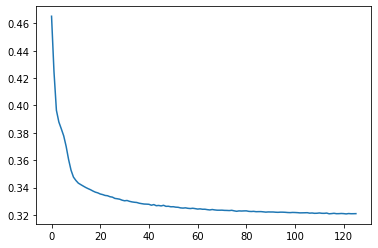

In [19]:
import matplotlib.pyplot as plt
loss_values = model.loss_curve_
print (loss_values)
plt.plot(loss_values)
plt.show()

In [20]:
number = preprocessing.LabelEncoder()
c = X['location_description'].unique()
b = X['primary_type'].unique()
encoded_loc = number.fit_transform(c).astype('int')
encoded_type = number.fit_transform(b).astype('int')
loc_dict = dict(zip(c,encoded_loc))
type_dict = dict(zip(b,encoded_type))

file = os.path.join("..","Resources", "loc_dict.csv") 

with open(file, "w", newline='') as outfile:
    w = csv.writer(outfile)
    for key, val in loc_dict.items():
        w.writerow([key, val])

file = os.path.join("..","Resources", "type_dict.csv") 

with open(file, "w", newline='') as outfile:
    w = csv.writer(outfile)
    for key, val in type_dict.items():
        w.writerow([key, val])   


In [21]:
file = os.path.join("..","Resources", "loc_dict.csv")
reader = csv.reader(open(file, 'r'))
loc_dict = {}
for row in reader:
    #print(row)
    k, v = row
    loc_dict[k] = v

In [22]:
file = os.path.join("..","Resources", "type_dict.csv")
reader = csv.reader(open(file, 'r'))
type_dict = {}
for row in reader:
    #print(row)
    k, v = row
    type_dict[k] = v

In [23]:
month = 6
hour = 15
day_of_week = 4
location_description = int(loc_dict.get('AIRPORT BUILDING NON-TERMINAL - SECURE AREA'))
primary_type =int(type_dict.get('BURGLARY'))

filename='MLP_model.pkl'
# Load from file
with open(filename, 'rb') as file:
    pickle_model = pickle.load(file)
    
print(model.predict([[month, hour, day_of_week,location_description,primary_type]]))

TypeError: int() argument must be a string, a bytes-like object or a number, not 'NoneType'

In [ ]:
month = 6
hour = 15
day_of_week = 4
location_description = int(loc_dict.get('AIRPORT BUILDING NON-TERMINAL - SECURE AREA'))
primary_type =int(type_dict.get('BURGLARY'))

filename='RF_model.sav'
# Load from file
model = joblib.load(filename)
    
print(model.predict([[month, hour, day_of_week,location_description,primary_type]]))
